## Tutorial 4: Machine Learning and Programming in Python

This tutorial covers tree algorithms. Firstly, we start with a Regression Trees and will than focus on Tree based methods for classification.




#### Dear Students, please prepare for the upcoming tutorial. Improving your coding skills involves a trial and error approach. Try to familiarize yourself with Python and the underlying algorithms. Your codes don't need to be perfect or identical, but you should be ready to actively participate in the upcoming discussion!

## Bagged Trees for Classifciation

In the following the titanic dataset is included in order to perform tree based classification methods:

    - Survived: Whether the passenger survived or not (0 = No, 1 = Yes)
    - Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
    - Name: Passenger's name
    - Sex: Passenger's sex (male or female)
    - Age: Passenger's age
    - SibSp: Number of siblings/spouses aboard the Titanic
    - Parch: Number of parents/children aboard the Titanic
    - Ticket: Ticket number
    - Fare: Passenger fare
    - Cabin: Cabin number
    - Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt #For the upcoming plots
from sklearn.model_selection import train_test_split

# Load the dataset
titanic = pd.read_csv('Titanicdata.csv')

# Check for NaNs
print("Any NaNs before cleaning?",titanic.isna().any().any())

nan_counts = titanic.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nans = nan_counts[nan_counts > 0]

# Print the columns with NaN values
print("Columns with NaN values:")
print(columns_with_nans)

# Dropping all NaNs
titanic.dropna(subset=['Age'], inplace=True)

# Drop the 'Cabin' column, as dropping 687 rows from the dataset makes it rather small
titanic.drop(columns=['Cabin'], inplace=True)

# Drop NaNs of column Embarked, as the number of NaNs is small
titanic.dropna(subset=['Embarked'], inplace=True)

print("Any NaNs after cleaning?",titanic.isna().any().any())

# Additionally, drop unnecessary columns
titanic.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})

titanic.Pclass = titanic.Pclass.apply(str)

titanic = pd.get_dummies(titanic, prefix_sep='_', drop_first=True, dtype=float)

ind_var = titanic.drop('Survived', axis=1) #Drop dependent Variable

dep_var = titanic['Survived']

X_train_tit, X_test_tit, y_train_tit, y_test_tit = train_test_split(ind_var, dep_var, test_size=0.3, random_state =10)



Any NaNs before cleaning? True
Columns with NaN values:
Age         177
Cabin       687
Embarked      2
dtype: int64
Any NaNs after cleaning? False


The provided code illustrates the implementation of Bagging for classification. Bagging involves constructing multiple classification trees, each trained on bootstrapped subsets of the data. These trees are then combined using majority voting, where the final prediction is determined by the most frequent class prediction across all trees. The number of bootstrapped samples B (or the number of fittet trees) is not a critical parameter for bagging, i.e. a large value of B will not lead to overfitting. Use a value of B sufficiently large such that the error goes down.

##### The bagged tree has the following attributes:
- "estimator": Specifies the base model that is trained on each bootstrapped subset of the data.
- "n_estimators": Determines the number of bootstrapped samples in which each tree is grown. For instance, setting it to twenty means that the Bagging ensemble will consist of twenty bootstrapped subtrees.
- "bootstrap": Indicates whether sampling is done with replacement from the original training set.
- "oob_score": Specifies whether the out-of-bag accuracy estimate should be calculated or not.
- "n_jobs": Useful for increasing computational efficiency, where "-1" utilizes all available processors for training the ensemble.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fit a bagging classifier
bagging = BaggingClassifier(estimator = DecisionTreeClassifier(criterion='gini'), n_estimators = 20, bootstrap = True, bootstrap_features = True ,oob_score = True, n_jobs = -1, random_state=10)
bagging.fit(X_train_tit, y_train_tit)

# Make predictions on the test set
y_pred_train = bagging.predict(X_train_tit)

# Make predictions on the test set
y_pred = bagging.predict(X_test_tit)

# Evaluate the model
accuracy = accuracy_score(y_train_tit, y_pred_train)
conf_matrix = confusion_matrix(y_train_tit, y_pred_train)
class_report = classification_report(y_train_tit, y_pred_train)

print("Accuracy (train):", accuracy)
print("Confusion Matrix (train):\n", conf_matrix)
print("Classification Report (train):\n", class_report)

# Evaluate the model
accuracy = accuracy_score(y_test_tit, y_pred)
conf_matrix = confusion_matrix(y_test_tit, y_pred)
class_report = classification_report(y_test_tit, y_pred)

print("Accuracy (test):", accuracy)
print("Confusion Matrix (test):\n", conf_matrix)
print("Classification Report (test):\n", class_report)



Accuracy (train): 0.9759036144578314
Confusion Matrix (train):
 [[299   1]
 [ 11 187]]
Classification Report (train):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       300
           1       0.99      0.94      0.97       198

    accuracy                           0.98       498
   macro avg       0.98      0.97      0.97       498
weighted avg       0.98      0.98      0.98       498

Accuracy (test): 0.822429906542056
Confusion Matrix (test):
 [[111  13]
 [ 25  65]]
Classification Report (test):
               precision    recall  f1-score   support

           0       0.82      0.90      0.85       124
           1       0.83      0.72      0.77        90

    accuracy                           0.82       214
   macro avg       0.82      0.81      0.81       214
weighted avg       0.82      0.82      0.82       214



#### Finding an appropriate number of bootstrapped subsamples
The loop does the following:
- Initialize an empty list to store the out-of-bag errors and define a grid of numbers representing the bootstrapped subsamples to iterate over.
- Iterate over the grid and define the model inside the loop.
- For each number of bootstrapped subsamples, fit the model and calculate the out-of-bag error.
- Append the computed out-of-bag error to the empty list previously initialized.

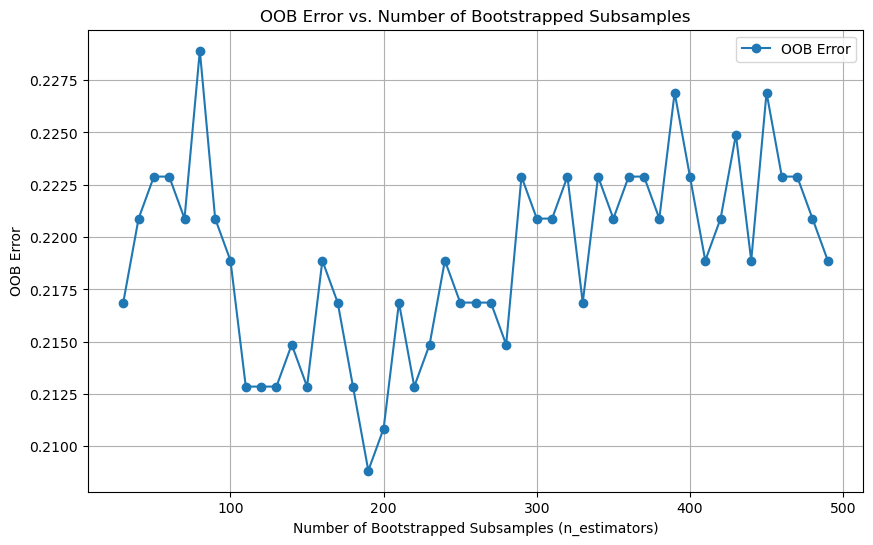

In [3]:
# List to store OOB error results
oob_error = []
n_estimators_range = range(30, 500, 10)

# Loop over number of bootstrapped subsamples (n_estimators)
for n_estimators in n_estimators_range:
    # Initialize BaggingClassifier with varying n_estimators
    bagging = BaggingClassifier(
        estimator=DecisionTreeClassifier(criterion='gini'),
        n_estimators=n_estimators,
        bootstrap=True,
        bootstrap_features = False,
        oob_score=True,
        n_jobs=-1,
        random_state=10
    )
    
    # Fit the model on the training data
    bagging.fit(X_train_tit, y_train_tit) 
    
    # Get the OOB error
    oob_error.append(1 - bagging.oob_score_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, oob_error, label='OOB Error', marker='o')
plt.xlabel('Number of Bootstrapped Subsamples (n_estimators)')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Number of Bootstrapped Subsamples')
plt.legend()
plt.grid(True)
plt.show()

The graph displays the out-of-bag error for various numbers of bootstrapped subsamples. The optimal model is selected based on the smallest out-of-bag error, which in this case corresponds to 190 bootstrapped subsamples for the final BaggingClassifier.

In addition to visually identifying the optimal number of bootstrapped subsamples, one can programmatically determine it by sorting all models based on their out-of-bag errors in descending order. The model with the lowest out-of-bag error indicates the optimal number of bootstrapped subsamples, which is then used in the final training and testing phases of the BaggingClassifier. This is done in the following code:

In [4]:
# List to store OOB error results
oob_error = []
models = []
n_estimators_range = range(30, 500, 10)

# Loop over number of bootstrapped subsamples (n_estimators)
for n_estimators in n_estimators_range:
    # Initialize BaggingClassifier with varying n_estimators
    bagging = BaggingClassifier(
        estimator=DecisionTreeClassifier(criterion='gini'),
        n_estimators=n_estimators,
        bootstrap=True,
        bootstrap_features = False,
        oob_score=True,
        n_jobs=-1,
        random_state=10
    )
    
    # Fit the model on the training data
    bagging.fit(X_train_tit, y_train_tit) 
    
    # Get the OOB error
    oob_error_value = 1- bagging.oob_score_
    oob_error.append(oob_error_value)
    models.append(bagging)

# Determine the model with the lowest OOB error
best_index = np.argmin(oob_error)
best_model = models[best_index]
best_n_estimators = n_estimators_range[best_index]

# Print the best number of estimators
print(f"Best number of estimators: {best_n_estimators}")
print(f"Lowest OOB error: {oob_error[best_index]}")

# Evaluate the best model on the training set
y_pred_train = best_model.predict(X_train_tit)
train_accuracy = accuracy_score(y_train_tit, y_pred_train)
train_conf_matrix = confusion_matrix(y_train_tit, y_pred_train)
train_class_report = classification_report(y_train_tit, y_pred_train)

print("Accuracy (train):", train_accuracy)
print("Confusion Matrix (train):\n", train_conf_matrix)
print("Classification Report (train):\n", train_class_report)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_tit)
test_accuracy = accuracy_score(y_test_tit, y_pred)
test_conf_matrix = confusion_matrix(y_test_tit, y_pred)
test_class_report = classification_report(y_test_tit, y_pred)

print("Accuracy (test):", test_accuracy)
print("Confusion Matrix (test):\n", test_conf_matrix)
print("Classification Report (test):\n", test_class_report)



Best number of estimators: 190
Lowest OOB error: 0.2088353413654619
Accuracy (train): 0.9959839357429718
Confusion Matrix (train):
 [[300   0]
 [  2 196]]
Classification Report (train):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       1.00      0.99      0.99       198

    accuracy                           1.00       498
   macro avg       1.00      0.99      1.00       498
weighted avg       1.00      1.00      1.00       498

Accuracy (test): 0.8317757009345794
Confusion Matrix (test):
 [[109  15]
 [ 21  69]]
Classification Report (test):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       124
           1       0.82      0.77      0.79        90

    accuracy                           0.83       214
   macro avg       0.83      0.82      0.83       214
weighted avg       0.83      0.83      0.83       214



Ensemble methods, including bagging, present a challenge in terms of model interpretability because they involve combining multiple models, making it impractical to visualize a single classification tree. One approach to address this challenge is through relative variable importance. This method quantifies the mean decrease in the Gini index attributed to each predictor. In essence, it measures the total reduction in Gini index across all bootstrapped subsamples for a particular predictor, averaged over the number of bootstrap samples. Relative variable importance is defined by expressing each variable's importance as a percentage relative to the most important variable. The most important variable is identified as the one with the highest average decrease in the Gini index across all bootstrap subsamples. This method allows for a clear comparison of each variable's contribution to the model's predictive power relative to the most important predictor.

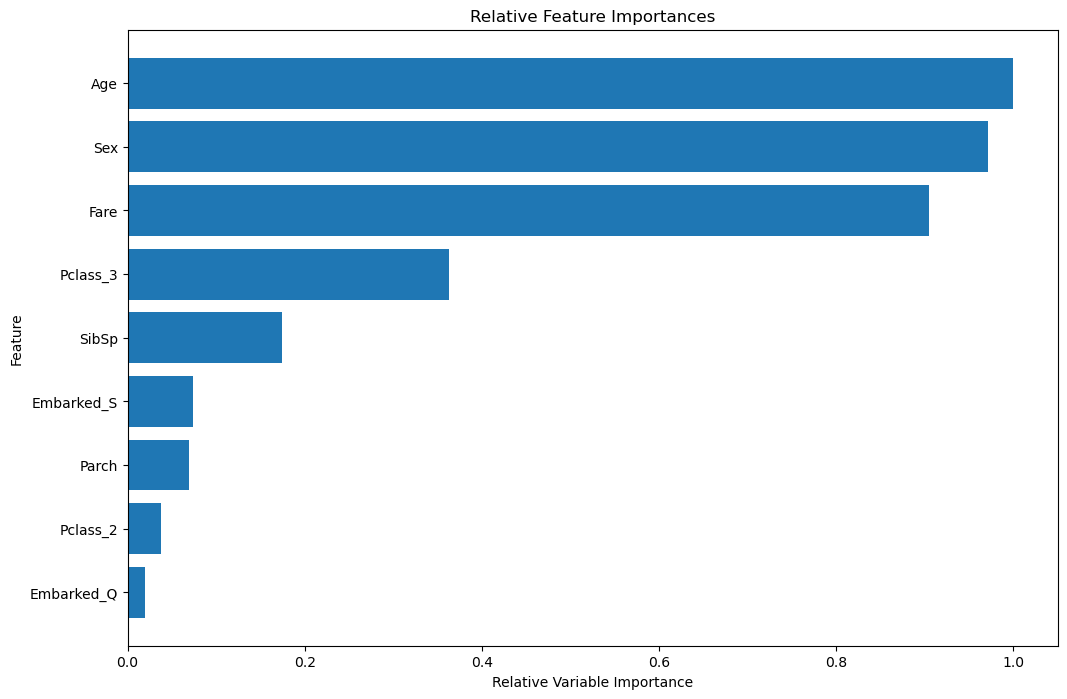

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the feature importances from the best model (compute mean feature importance for all features!)
importances = np.mean([feature.feature_importances_ for feature in best_model.estimators_], axis=0)

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort importances in descending order
sorted_importances = importances[sorted_indices]

# Calculate relative importances based on the most important feature
relative_importances = sorted_importances / sorted_importances[0]

# Get the feature names
feature_names = X_train_tit.columns

# Get sorted feature names based on sorted importances
sorted_feature_names = feature_names[sorted_indices]

# Plot the relative feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, relative_importances, align='center')
plt.xlabel('Relative Variable Importance')
plt.ylabel('Feature')
plt.title('Relative Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

The plot interpretation is as follows:
- Age emerges as the most crucial variable, exhibiting the largest average decrease in the Gini index across all subtrees.
- Sex ranks second in importance, approximately 98% as important as Age.
- Fare follows as the third most important variable, approximately 90% as important as Age.
  

### Bagged Trees for Regression

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_housing = pd.read_csv('boston_house_prices.csv', skiprows=1, names=column_names)

# Delete first row (variable descriptions)
boston_housing = boston_housing.drop(index=0)

# Convert all columns to numeric
boston_housing = boston_housing.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
boston_housing = boston_housing.dropna()

# Split data into features (X) and target (y)
X = boston_housing.drop(columns=['MEDV'])
y = boston_housing['MEDV']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Implement a bagged regression tree. Include the following steps in your implementation and describe your procedure:
- Implement one bagged regression tree using a fixed number of bootstrapped subsamples.
- mplement a graph to select the number of bootstrapped subtrees where the out-of-bag error is minimized.
- Implement a loop to select the number of bootstrapped subsamples for the final training and testing phases of the bagged regression tree.
- Implement calculation of relative variable importance.

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

## Random Forest

#### Random Forest for Classification
The provided code demonstrates the implementation of the Random Forest classifier. Random Forest utilizes bagging, where multiple decision trees are trained on bootstrapped samples of the training data. The key distinction is that Random Forest introduces additional randomness by considering only a random subset of predictors at each split in the decision trees. This approach reduces variance through aggregation via majority voting, leveraging the cancellation of noise and errors across the ensemble of trees.

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier


# Fit a bagging classifier
RF = RandomForestClassifier(n_estimators = 30, criterion = "gini", max_features = "sqrt", bootstrap = True, oob_score = True, n_jobs = -1, random_state=10)
RF.fit(X_train_tit, y_train_tit)

# Make predictions on the test set
y_pred_train = RF.predict(X_train_tit)

# Make predictions on the test set
y_pred = RF.predict(X_test_tit)

# Evaluate the model
accuracy = accuracy_score(y_train_tit, y_pred_train)
conf_matrix = confusion_matrix(y_train_tit, y_pred_train)
class_report = classification_report(y_train_tit, y_pred_train)

print("Accuracy (train):", accuracy)
print("Confusion Matrix (train):\n", conf_matrix)
print("Classification Report (train):\n", class_report)

# Evaluate the model
accuracy = accuracy_score(y_test_tit, y_pred)
conf_matrix = confusion_matrix(y_test_tit, y_pred)
class_report = classification_report(y_test_tit, y_pred)

print("Accuracy (test):", accuracy)
print("Confusion Matrix (test):\n", conf_matrix)
print("Classification Report (test):\n", class_report)

Accuracy (train): 0.9939759036144579
Confusion Matrix (train):
 [[300   0]
 [  3 195]]
Classification Report (train):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       1.00      0.98      0.99       198

    accuracy                           0.99       498
   macro avg       1.00      0.99      0.99       498
weighted avg       0.99      0.99      0.99       498

Accuracy (test): 0.822429906542056
Confusion Matrix (test):
 [[111  13]
 [ 25  65]]
Classification Report (test):
               precision    recall  f1-score   support

           0       0.82      0.90      0.85       124
           1       0.83      0.72      0.77        90

    accuracy                           0.82       214
   macro avg       0.82      0.81      0.81       214
weighted avg       0.82      0.82      0.82       214



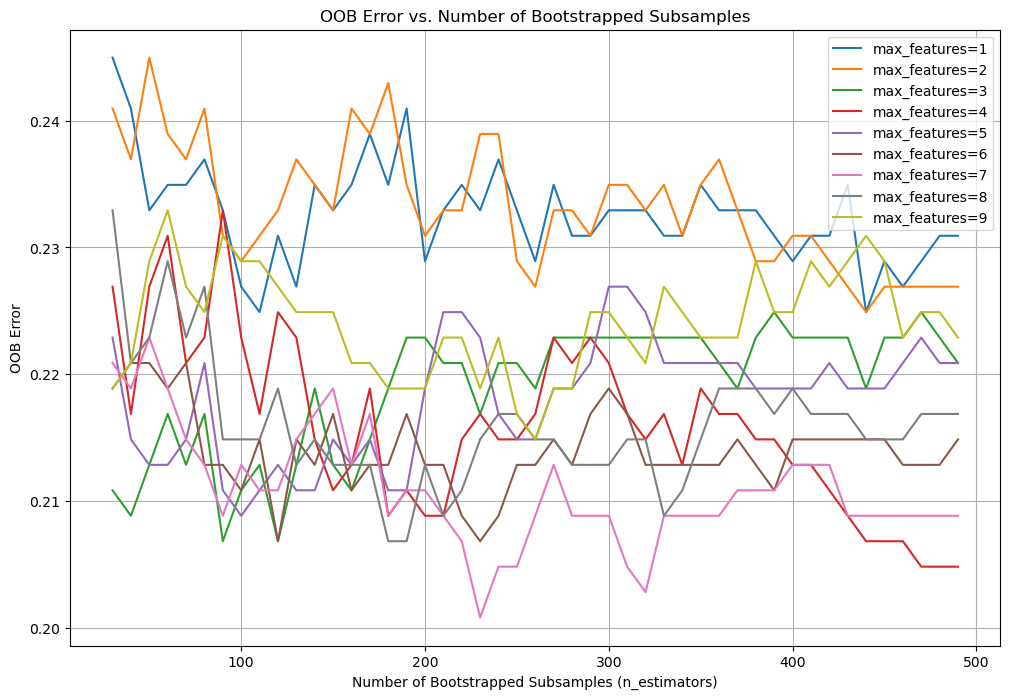

In [9]:
# List to store OOB error results
oob_error = []
n_estimators_range = range(30, 500, 10)
max_features_range = range(1, len(X_train_tit.columns) + 1)  

# Loop over number of bootstrapped subsamples (n_estimators)
for n_estimators in n_estimators_range:
    for max_features in max_features_range:
        # Initialize RandomForestClassifier with varying n_estimators and max_features
        RF = RandomForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            criterion="gini",
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=10
        )
        
        # Fit the model on the training data
        RF.fit(X_train_tit, y_train_tit) 
        
        # Get the OOB error and append to the list
        oob_error.append((n_estimators, max_features, 1 - RF.oob_score_))

# Convert the list to a structured array for easier plotting
oob_error = np.array(oob_error, dtype=[('n_estimators', int), ('max_features', int), ('oob_error', float)])

# Plot the results
plt.figure(figsize=(12, 8))

for max_features in max_features_range:
    subset = oob_error[oob_error['max_features'] == max_features]
    plt.plot(subset['n_estimators'], subset['oob_error'], label=f'max_features={max_features}')

plt.xlabel('Number of Bootstrapped Subsamples (n_estimators)')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Number of Bootstrapped Subsamples')
plt.legend()
plt.grid(True)
plt.show()

The resulting graph shows the out-of-bag error plotted against the number of bootstrapped subsamples for each number of random predictors. From this graph, it is evident that the lowest out-of-bag error occurs at around 230 bootstrapped subsamples with 7 random predictors (pink line) at each split of the subtree.

In [10]:
# List to store OOB error results and models
oob_error = []
models = []
parameters = []

n_estimators_range = range(30, 500, 10)
max_features_range = range(1, len(X_train_tit.columns) + 1)

# Loop over number of bootstrapped subsamples (n_estimators)
for n_estimators in n_estimators_range:
    for max_features in max_features_range:
        # Initialize RandomForestClassifier with varying n_estimators and max_features
        RF = RandomForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            criterion="gini",
            bootstrap=True,
            oob_score=True,
            n_jobs=-1,
            random_state=10
        )
        
        # Fit the model on the training data
        RF.fit(X_train_tit, y_train_tit) 
        
        # Get the OOB error
        oob_error_value = 1 - RF.oob_score_
        oob_error.append(oob_error_value)
        models.append(RF)
        parameters.append((n_estimators, max_features))

# Determine the model with the lowest OOB error
best_index = np.argmin(oob_error)
best_model = models[best_index]
best_n_estimators, best_max_features = parameters[best_index]

# Print the best number of estimators and max_features
print(f"Best number of estimators: {best_n_estimators}")
print(f"Best number of max_features: {best_max_features}")
print(f"Lowest OOB error: {oob_error[best_index]}")

# Evaluate the best model on the training set
y_pred_train = best_model.predict(X_train_tit)
train_accuracy = accuracy_score(y_train_tit, y_pred_train)
train_conf_matrix = confusion_matrix(y_train_tit, y_pred_train)
train_class_report = classification_report(y_train_tit, y_pred_train)

print("Accuracy (train):", train_accuracy)
print("Confusion Matrix (train):\n", train_conf_matrix)
print("Classification Report (train):\n", train_class_report)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_tit)
test_accuracy = accuracy_score(y_test_tit, y_pred)
test_conf_matrix = confusion_matrix(y_test_tit, y_pred)
test_class_report = classification_report(y_test_tit, y_pred)

print("Accuracy (test):", test_accuracy)
print("Confusion Matrix (test):\n", test_conf_matrix)
print("Classification Report (test):\n", test_class_report)

Best number of estimators: 230
Best number of max_features: 7
Lowest OOB error: 0.20080321285140568
Accuracy (train): 0.9959839357429718
Confusion Matrix (train):
 [[299   1]
 [  1 197]]
Classification Report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      0.99      0.99       198

    accuracy                           1.00       498
   macro avg       1.00      1.00      1.00       498
weighted avg       1.00      1.00      1.00       498

Accuracy (test): 0.8317757009345794
Confusion Matrix (test):
 [[109  15]
 [ 21  69]]
Classification Report (test):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       124
           1       0.82      0.77      0.79        90

    accuracy                           0.83       214
   macro avg       0.83      0.82      0.83       214
weighted avg       0.83      0.83      0.83       214



This code highlights the findings from the previously discussed graph. The results show that the optimal number of bootstrapped subsamples is 230, with 7 random predictors at each split.


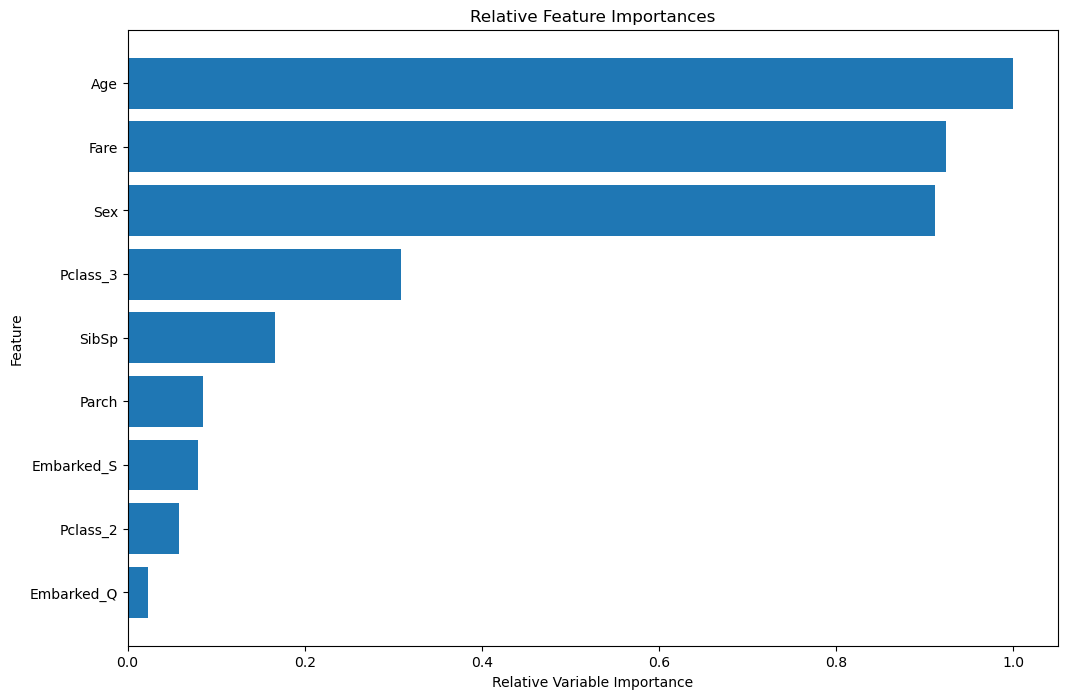

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the feature importances from the best model (compute mean feature importance for all features!)
importances = np.mean([feature.feature_importances_ for feature in best_model.estimators_], axis=0)

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Sort importances in descending order
sorted_importances = importances[sorted_indices]

# Calculate relative importances based on the most important feature
relative_importances = sorted_importances / sorted_importances[0]

# Get the feature names
feature_names = X_train_tit.columns

# Get sorted feature names based on sorted importances
sorted_feature_names = feature_names[sorted_indices]

# Plot the relative feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, relative_importances, align='center')
plt.xlabel('Relative Variable Importance')
plt.ylabel('Feature')
plt.title('Relative Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

Interpretation:
- The variable Age is the most important variable, showing the highest average decrease in the Gini index across all subtrees.
- The second most important variable is Fare, which is approximately 90% as important as Age.

#### Random Forest for Regression

In [12]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Load the dataset and set the column names
boston_housing = pd.read_csv('boston_house_prices.csv', skiprows=1, names=column_names)

#Delete first row, due to the inclusion of variable description in the first row
boston_housing = boston_housing.drop(index=0)

#Converting all columns to numeric
boston_housing = boston_housing.apply(pd.to_numeric, errors='coerce')

#Check for NaNs
print("Any NaNs?",boston_housing.isna().any().any())


Any NaNs? False


In [13]:
from sklearn.model_selection import train_test_split

ind_var = boston_housing.drop('MEDV', axis=1) #Drop independent Variables

dep_var = boston_housing['MEDV']

X_train, X_test, y_train, y_test = train_test_split(ind_var, dep_var, test_size=0.3, random_state =10)


Implement a Random Forest for regression. Include the following steps in your implementation and describe your procedure:
- Implement one Random Forest using a fixed number of bootstrapped subsamples and a fixed number of random predictors.
- Implement a graph to select the number of bootstrapped subtrees and the optimal number of random predictors where the out-of-bag error is minimized.
- Implement a loop to select the number of bootstrapped subsamples for the final training and testing phases of the bagged regression tree.
- Implement calculation of relative variable importance.

In [14]:
# Fit a bagging classifier
RF = RandomForestRegressor(n_estimators = 30, criterion = "squared_error", max_features = "sqrt", bootstrap = True, oob_score = True, n_jobs = -1, random_state=10)
RF.fit(X_train_tit, y_train_tit)

# Make predictions on the test set
y_pred_train = RF.predict(X_train)

# Make predictions on the test set
y_pred = RF.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_train_tit, y_pred_train)
conf_matrix = confusion_matrix(y_train_tit, y_pred_train)
class_report = classification_report(y_train_tit, y_pred_train)

print("Accuracy (train):", accuracy)
print("Confusion Matrix (train):\n", conf_matrix)
print("Classification Report (train):\n", class_report)

# Evaluate the model
accuracy = accuracy_score(y_test_tit, y_pred)
conf_matrix = confusion_matrix(y_test_tit, y_pred)
class_report = classification_report(y_test_tit, y_pred)

print("Accuracy (test):", accuracy)
print("Confusion Matrix (test):\n", conf_matrix)
print("Classification Report (test):\n", class_report)

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
# List to store OOB error results
oob_error = []
n_estimators_range = range(30, 500, 10)

# Loop over number of bootstrapped subsamples (n_estimators)
for n_estimators in n_estimators_range:
    # Initialize BaggingClassifier with varying n_estimators
    bagging = BaggingClassifier(
        estimator=DecisionTreeRegressor(criterion='squared_error'),
        n_estimators=n_estimators,
        bootstrap=True,
        bootstrap_features = False,
        oob_score=True,
        n_jobs=-1,
        random_state=10
    )
    
    # Fit the model on the training data
    bagging.fit(X_train_tit, y_train_tit) 
    
    # Get the OOB error
    oob_error.append(1 - bagging.oob_score_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, oob_error, label='OOB Error', marker='o')
plt.xlabel('Number of Bootstrapped Subsamples (n_estimators)')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Number of Bootstrapped Subsamples')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# List to store OOB error results
oob_error = []
models = []
n_estimators_range = range(30, 500, 10)

# Loop over number of bootstrapped subsamples (n_estimators)
for n_estimators in n_estimators_range:
    # Initialize BaggingClassifier with varying n_estimators
    bagging = BaggingClassifier(
        estimator=DecisionTreeClassifier(criterion='gini'),
        n_estimators=n_estimators,
        bootstrap=True,
        bootstrap_features = False,
        oob_score=True,
        n_jobs=-1,
        random_state=10
    )
    
    # Fit the model on the training data
    bagging.fit(X_train_tit, y_train_tit) 
    
    # Get the OOB error
    oob_error_value = 1- bagging.oob_score_
    oob_error.append(oob_error_value)
    models.append(bagging)

# Determine the model with the lowest OOB error
best_index = np.argmin(oob_error)
best_model = models[best_index]
best_n_estimators = n_estimators_range[best_index]

# Print the best number of estimators
print(f"Best number of estimators: {best_n_estimators}")
print(f"Lowest OOB error: {oob_error[best_index]}")

# Evaluate the best model on the training set
y_pred_train = best_model.predict(X_train_tit)
train_accuracy = accuracy_score(y_train_tit, y_pred_train)
train_conf_matrix = confusion_matrix(y_train_tit, y_pred_train)
train_class_report = classification_report(y_train_tit, y_pred_train)

print("Accuracy (train):", train_accuracy)
print("Confusion Matrix (train):\n", train_conf_matrix)
print("Classification Report (train):\n", train_class_report)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_tit)
test_accuracy = accuracy_score(y_test_tit, y_pred)
test_conf_matrix = confusion_matrix(y_test_tit, y_pred)
test_class_report = classification_report(y_test_tit, y_pred)

print("Accuracy (test):", test_accuracy)
print("Confusion Matrix (test):\n", test_conf_matrix)
print("Classification Report (test):\n", test_class_report)